# Comparison with MCMC

Import

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
import nbi
import smart
import emcee
import corner
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform
from multiprocess.pool import Pool
from matplotlib.lines import Line2D

warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

Setup Path

In [2]:
user_path = os.path.expanduser('~')
data_path = '/stow/weilingfeng/data/apogee'
model_path = f'{data_path}/nbi_5_params'
mcmc_path = f'{user_path}/ML/Group7-Project/data/mcmc'
figure_path = f'{user_path}/ML/Group7-Project/figure'

if not os.path.exists(mcmc_path):
    os.makedirs(mcmc_path)

Read simulated spectra

In [3]:
# Read simulated spectra
with open(f'{data_path}/simulated_spectra_5_params.pkl', 'rb') as file:
    simulated_spectra = pickle.load(file)

wave = simulated_spectra['wave']
flux = simulated_spectra['flux']
params = np.array([simulated_spectra[_] for _ in ['teff', 'rv', 'vsini', 'logg', 'metal']]).T

Define noise function

In [4]:
def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])

    # let's say x_err is drawn from [0, 0.03]
    x_err = np.random.uniform() * 0.03
    x_noise = x + rand * x_err * x
    return x_noise, y

Define priors

In [5]:
prior = {
    'teff':     uniform(loc=2300, scale=7000-2300),  # U(2300, 7000) K
    'rv':       uniform(loc=-200, scale=200-(-200)), # U(-200, 200) km/s
    'vsini':    uniform(loc=0, scale=100),           # U(0, 100) km/s
    'logg':     uniform(loc=2.5, scale=6-2.5),       # U(2.5, 6)
    'metal':    uniform(loc=-2.12, scale=0.5+2.12)   # U(-2.12, 0.5)
}

labels = list(prior.keys())
priors = [prior[k] for k in labels]

Read existing model

In [6]:
with open(f'{model_path}/best_model_path.txt', 'r') as file:
    best_model = file.read()

engine = nbi.NBI(
    state_dict=best_model,
    priors=priors,
    labels=labels,
    device='cuda',
    path=model_path,
    n_jobs=16
)

Define simulator function

In [7]:
# simulator
instrument = 'apogee'
order = 'all'
modelset = 'phoenix-aces-agss-cond-2011'
lsf  = simulated_spectra['lsf']
xlsf = simulated_spectra['xlsf']

def simulate_spectra(params):
    teff, rv, vsini, logg, metal = params
    model = smart.makeModel(teff=teff, rv=rv, vsini=vsini, logg=logg, metal=metal, instrument=instrument, order=order, modelset=modelset, lsf=lsf, xlsf=xlsf)
    model.flux = np.array(smart.integralResample(xh=model.wave, yh=model.flux, xl=wave))
    return model.flux

Sample a random spectrum from the prior

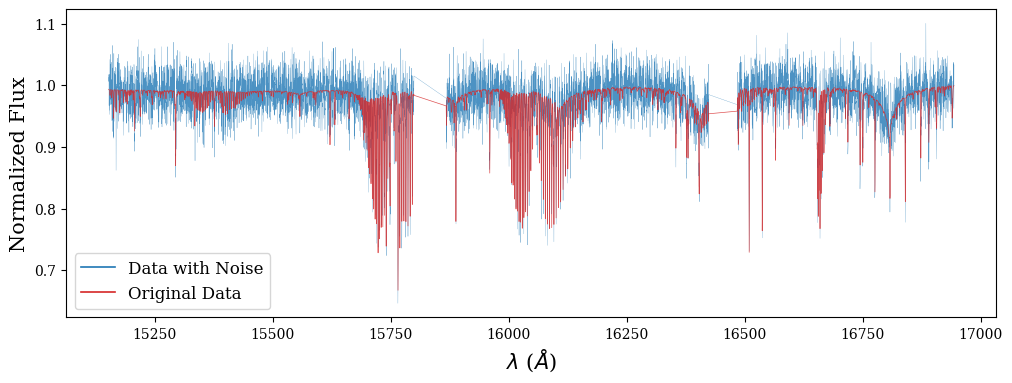

In [11]:
np.random.seed(29)
y_true = [var.rvs(1)[0] for var in priors]
x_err = 0.05
rand = np.random.uniform()
x_obs = simulate_spectra(y_true)
x_noisy = x_obs + rand * np.random.normal(size=len(wave)) * x_err
# x_noisy, _ = noise(x_obs, y_true)


legend_elements = [
    Line2D([], [], color='C0', lw=1.2, label='Data with Noise'),
    Line2D([], [], color='C3', lw=1.2, label='Original Data')
]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wave, x_noisy, color='C0', lw=0.2, alpha=0.8)
ax.plot(wave, x_obs, color='C3', lw=0.5, alpha=0.8)
ax.set_xlabel(r'$\lambda$ ($\AA$)', fontsize=15)
ax.set_ylabel('Normalized Flux', fontsize=15)
ax.legend(handles=legend_elements, fontsize=12)
plt.show()

NBI prediction

surrogate posterior


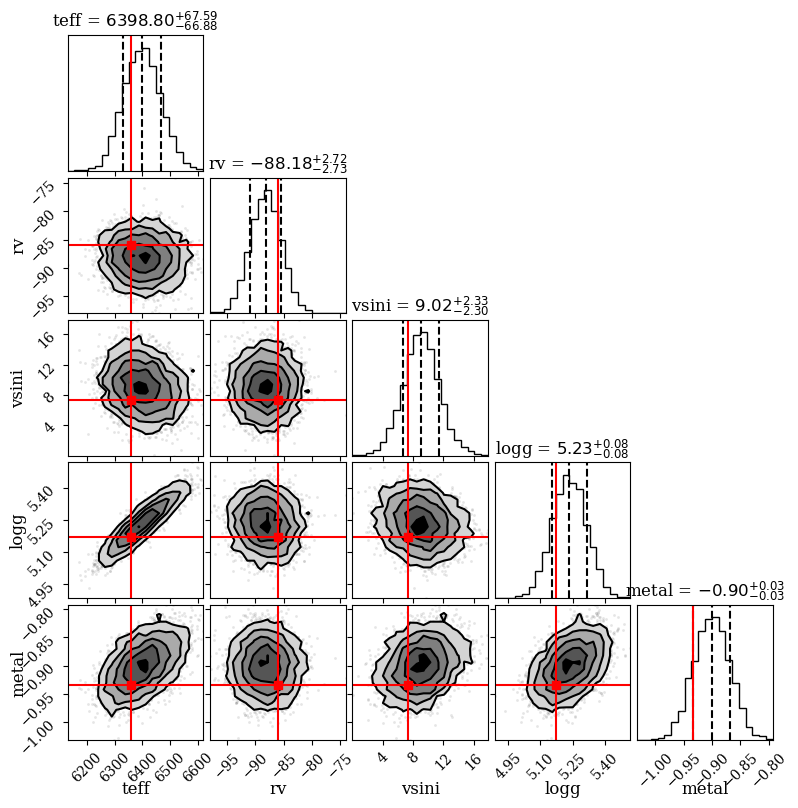

Generating simulations


320it [01:24,  3.80it/s]


Effective Sample Size = 73.7
Sampling efficiency = 1.4%


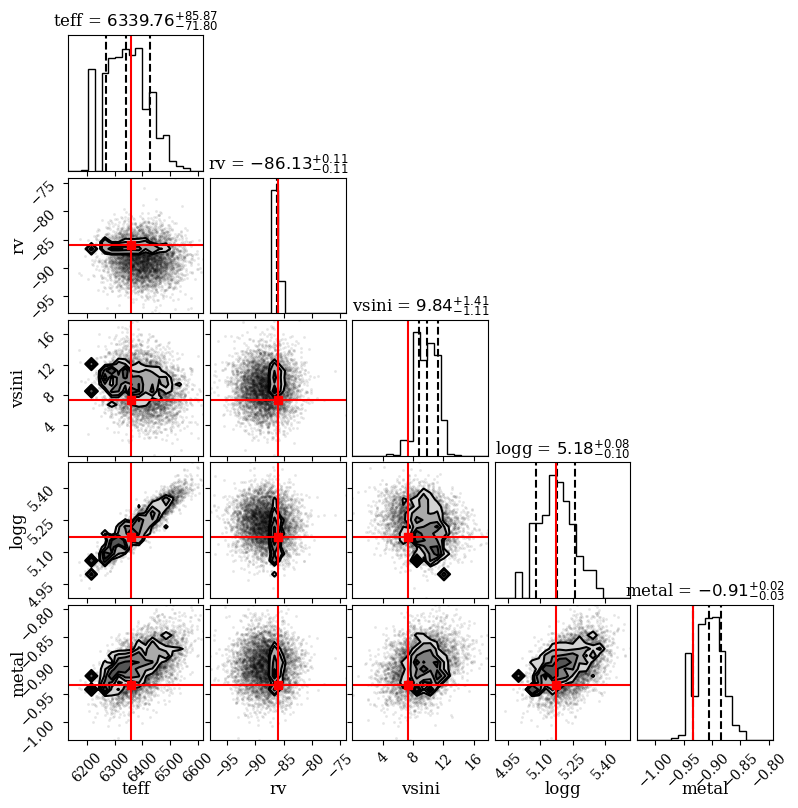

In [12]:
dim = len(wave)
engine.simulator = simulate_spectra
engine.n_jobs = 16
y_pred, weights = engine.predict(x_noisy, x_err=rand * x_err * np.ones_like(x_noisy), y_true=y_true, n_samples=5120, corner=True, corner_reweight=True, seed=0, save_path=figure_path)
plt.show()

Plot reconstructed spectra

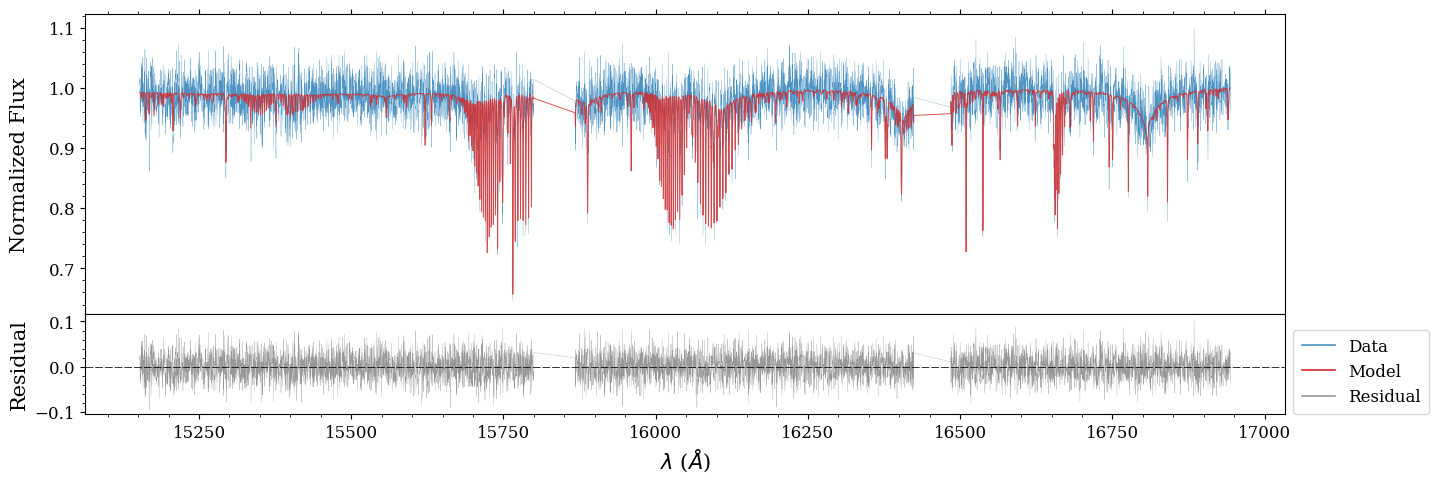

In [13]:
def plot_spectrum(wave, obs_spec, model_spec, alpha=0.8, save_path=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(wave, obs_spec, color='C0', alpha=alpha, lw=0.2)
    ax1.plot(wave, model_spec, color='C3', alpha=alpha, lw=0.7)
    ax2.plot(wave, obs_spec - model_spec, color='C7', alpha=alpha, lw=0.2)

    ax1.minorticks_on()
    ax1.xaxis.tick_top()
    ax1.tick_params(axis='both', labelsize=12, labeltop=False)  # don't put tick labels at the top
    ax1.set_ylabel('Normalized Flux', fontsize=15)
    h1, l1 = ax1.get_legend_handles_labels()

    ax2.axhline(y=0, color='k', linestyle='--', dashes=(8, 2), alpha=alpha, lw=0.7)
    ax2.minorticks_on()
    ax2.tick_params(axis='both', labelsize=12)
    ax2.set_xlabel(r'$\lambda$ ($\AA$)', fontsize=15)
    ax2.set_ylabel('Residual', fontsize=15)
    h2, l2 = ax2.get_legend_handles_labels()

    legend_elements = [
        Line2D([], [], color='C0', alpha=alpha, lw=1.2, label='Data'),
        Line2D([], [], color='C3', lw=1.2, label='Model'),
        Line2D([], [], color='C7', alpha=alpha, lw=1.2, label='Residual')
    ]

    ax2.legend(handles=legend_elements, frameon=True, loc='lower left', bbox_to_anchor=(1, -0.08), fontsize=12, borderpad=0.5)
    fig.align_ylabels((ax1, ax2))
    # ax1.set_title(f'APOGEE {apogee_id}, Teff={teff:.2f}±{e_teff:.2}, RV={rv:.2f}±{e_rv:.2f}, vsini={vsini:.2f}')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


y_pred_med = np.median(y_pred, axis=0)
plot_spectrum(wave, x_noisy, simulate_spectra(y_pred_med), save_path=f'{figure_path}/reconstructed spectra.pdf')

# MCMC

Define the likelihood functions

In [14]:
def lnprior(theta):
    teff, rv, vsini, logg, metal = theta
    if  2300    < teff      < 7000  \
    and -200    < rv        < 200   \
    and 0       < vsini     < 100   \
    and 2.5     < logg      < 6     \
    and -2.12   < metal     < 0.5:
        return 0.
    
    else:
        return -np.inf

def lnlike(theta, x_noisy):
    teff, rv, vsini, logg, metal = theta
    model = smart.makeModel(teff, logg=logg, vsini=vsini, rv=rv, metal=metal, instrument=instrument, order=order, modelset=modelset, lsf=lsf, xlsf=xlsf)
    model.flux = np.array(smart.integralResample(xh=model.wave, yh=model.flux, xl=wave))
    noise_array = 0.05
    sigma2 = noise_array**2
    chi = -1/2 * np.sum( (x_noisy - model.flux)**2 / sigma2 + np.log(2*np.pi*sigma2) )
    return chi

def lnprob(theta, x_noisy):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, x_noisy)

Setup parameters and initial state

In [17]:
nwalkers=100
nparams = len(labels)
steps = 300
discard = 200
initial_state = np.array([
    np.random.uniform(2300, 7000, size=nwalkers),
    np.random.uniform(-200, 200, size=nwalkers),
    np.random.uniform(0, 100, size=nwalkers),
    np.random.uniform(2.5, 6, size=nwalkers),
    np.random.uniform(-2.12, 0.5, size=nwalkers)
]).transpose()

Run MCMC

In [18]:
move = [emcee.moves.KDEMove()]

new_mcmc = True
if new_mcmc:
    backend = emcee.backends.HDFBackend(f'{mcmc_path}/sampler.h5')
    backend.reset(nwalkers, nparams)
    with Pool(32) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, nparams, lnprob, args=(x_noisy, ), moves=move, pool=pool)
        sampler.run_mcmc(initial_state, steps, progress=True)
else:
    sampler = emcee.backends.HDFBackend(f'{mcmc_path}/sampler.h5')


100%|██████████| 300/300 [07:39<00:00,  1.53s/it]


Get MCMC posteriors

In [19]:
flat_samples = sampler.get_chain(discard=discard, flat=True)

# mcmc[:, i] (2 by N) = [value, error]
mcmc = np.empty((2, nparams))
for i in range(nparams):
    mcmc[:, i] = np.array((np.median(flat_samples[:, i]), np.diff(np.percentile(flat_samples[:, i], [15.9, 84.1]))[0]/2))

mcmc = pd.DataFrame(mcmc, columns=labels)

MCMC Results

In [20]:
mcmc

,teff,rv,vsini,logg,metal
0,6359.261066,-86.175334,9.563375,5.192690,-0.904493
1,116.909419,0.323826,2.278221,0.141149,0.042433


Walker Plot

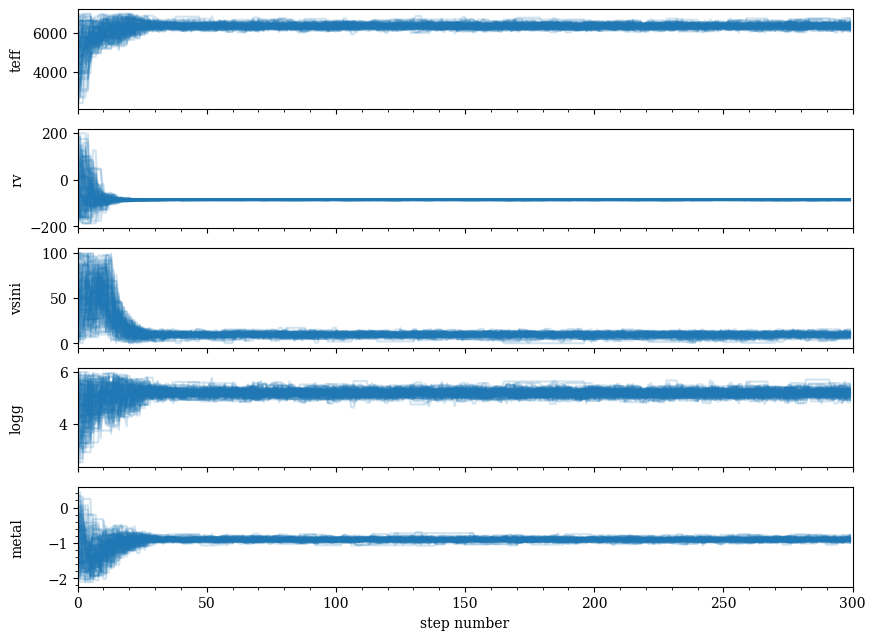

In [21]:
fig, axes = plt.subplots(nrows=nparams, ncols=1, figsize=(10, 1.5*nparams), sharex=True)
samples = sampler.get_chain()

for i in range(nparams):
    ax = axes[i]
    ax.plot(samples[:, :, i], "C0", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

ax.set_xlabel("step number");
plt.minorticks_on()
fig.align_ylabels()
plt.savefig(f'{mcmc_path}/mcmc_walker.png', dpi=300, bbox_inches='tight')
plt.show()

Corner Plot

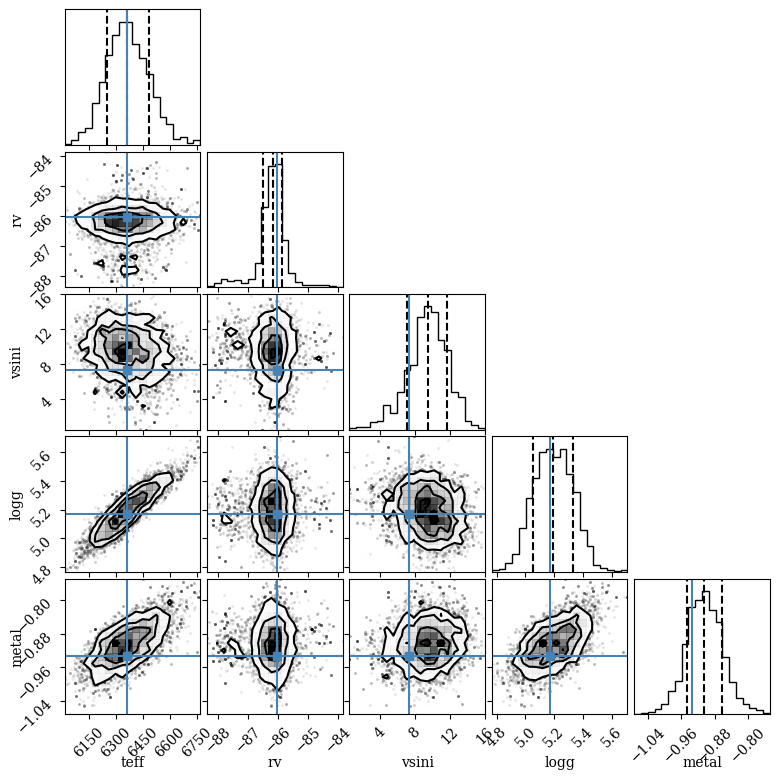

In [22]:
truths = mcmc.loc[0].to_numpy()
uncertainties = mcmc.loc[1].to_numpy()
titles = [
    f'{label}={truth:.2f} ± {uncertainty:.2f}' for label, truth, uncertainty in zip(labels, truths, uncertainties)
]
fig = corner.corner(
    flat_samples, labels=labels, truths=y_true, quantiles=[0.16, 0.5, 0.84], titles=titles
)
dim = len(labels)
fig.set_size_inches((dim + 3, dim + 3))
plt.savefig(f'{mcmc_path}/mcmc_corner.pdf', dpi=300, bbox_inches='tight')
plt.show()